In [1]:
import os
import re
import string
import unicodedata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from indoNLP.preprocessing import (
    emoji_to_words,
    remove_html,
    remove_url,
    replace_slang,
    replace_word_elongation,
    remove_stopwords,
)
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud

In [2]:
list_data = [
    "januari-2021.csv",
    "februari-2021.csv",
    "maret-2021.csv",
    "april-2021.csv",
    "mei-2021.csv",
    "juni-2021.csv",
    "juli-2021.csv",
    "agustus-2021.csv",
    "september-2021.csv",
    "oktober-2021.csv",
    "november-2021.csv",
    "desember-2021.csv",
]

local = "../data/"
if os.path.isdir(local):
    main_dir = local
else:
    main_dir = "https://raw.githubusercontent.com/Hyuto/skripsi/master/data/"

In [35]:
data = pd.concat([pd.read_csv(f"{main_dir}{x}") for x in list_data])
data["date"] = pd.to_datetime(data["date"]).dt.tz_localize(None)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457993 entries, 0 to 15958
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   date     457993 non-null  datetime64[ns]
 1   url      457993 non-null  object        
 2   user     457993 non-null  object        
 3   content  457993 non-null  object        
 4   likes    292455 non-null  float64       
 5   retweet  292455 non-null  float64       
 6   reply    292455 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 28.0+ MB


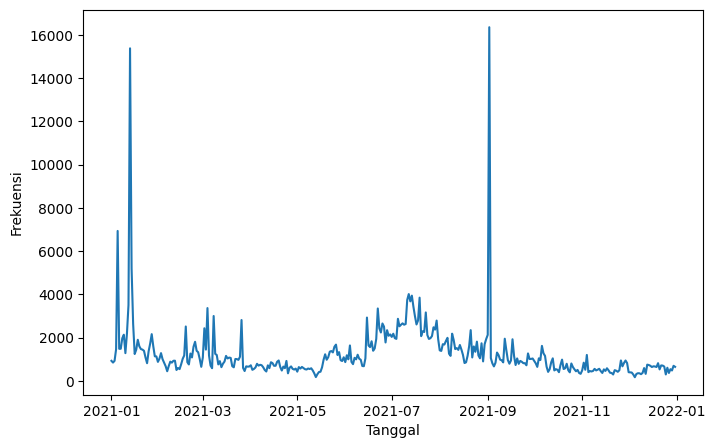

,date,count
0,2021-09-02,16360
1,2021-01-13,15383
2,2021-01-05,6932
3,2021-01-14,5197
4,2021-07-12,4011


In [39]:
tweet_freq = data["date"].dt.floor("d").value_counts().rename_axis("date").reset_index(name="count")
plt.figure(figsize=(8, 5))
sns.lineplot(x="date", y="count", data=tweet_freq)
#plt.title("Frekuensi Tweet Vaksin Covid-19 (Harian)", fontsize=12)
plt.xlabel("Tanggal")
plt.ylabel("Frekuensi")
plt.show()

tweet_freq.sort_values("count", ascending=False).head(5)

In [42]:
tweet_freq["count"].sum()

457993

In [31]:
STEMMER = StemmerFactory().create_stemmer()


def preprocessing(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text, flags=re.UNICODE)  # remove whitespace
    text = emoji_to_words(text)  # remove emoji
    text = unicodedata.normalize("NFD", text).encode("ascii", "ignore").decode("ascii")
    text = remove_html(text)  # remove html tags
    text = remove_url(text)  # remove url
    text = replace_word_elongation(text)
    text = replace_slang(text)  # replace slang words
    text = remove_stopwords(text)
    text = text.translate(str.maketrans("", "", string.digits))  # remove numbers
    text = text.translate(
        str.maketrans(string.punctuation, " " * len(string.punctuation))
    )  # remove punctuation
    text = " ".join(text.split())
    text = STEMMER.stem(text)
    return " ".join(text.split())

data.drop_duplicates("content", inplace=True)

# run app 30 min
# data["cleaned"] = [preprocessing(x) for x in tqdm(data["content"].values)]

with open(os.path.join("..", "data", "cleaned-text.txt")) as reader:
    data["cleaned"] = reader.read().split("\n")[:-1]

data.drop_duplicates("cleaned", inplace=True)  # drop duplicates

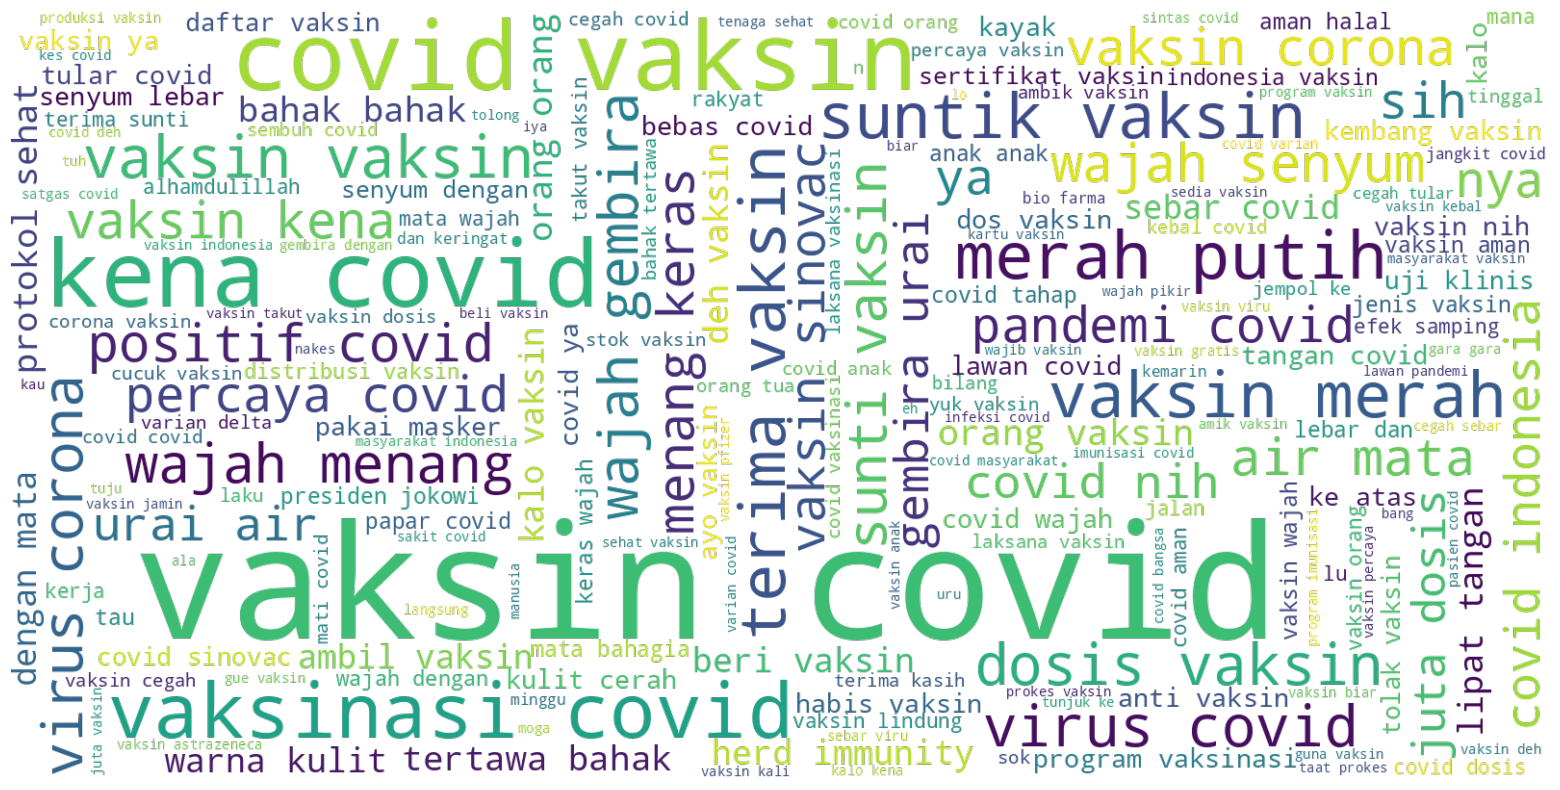

In [32]:
wordcloud = WordCloud(
    mode="RGBA",
    background_color=None,
    width=1600,
    height=800,
    random_state=2022,
    colormap="viridis",
)
wordcloud.generate(" ".join(data["cleaned"].tolist()))

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

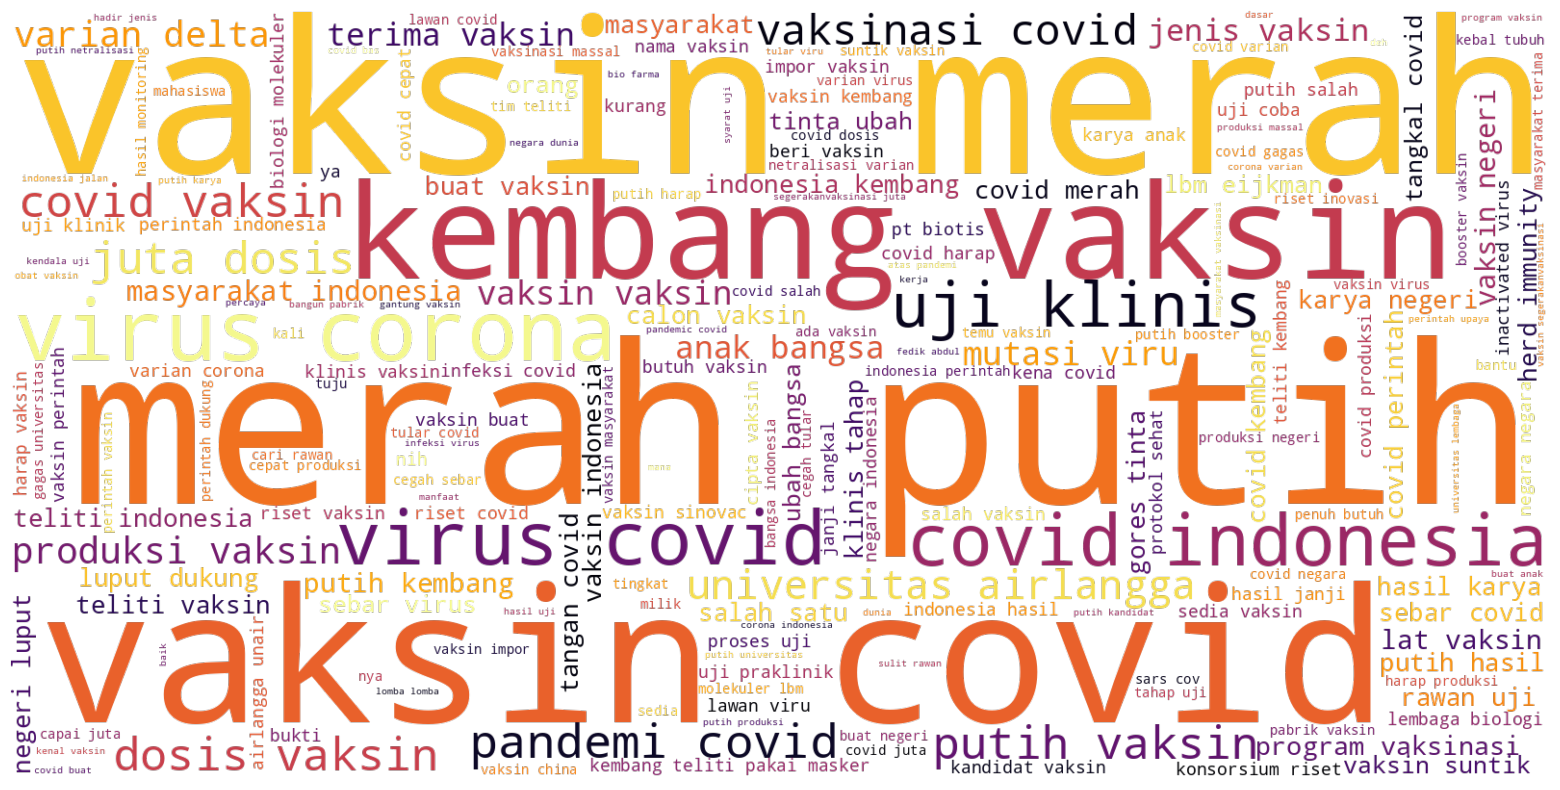

In [34]:
wordcloud = WordCloud(
    mode="RGBA",
    background_color=None,
    width=1600,
    height=800,
    random_state=2022,
    colormap="inferno",
)
wordcloud.generate(" ".join(data.query("'2021-09-01' < date < '2021-09-03'")["cleaned"].tolist()))

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()